# Week 11: The ROC curve for illusory shape discrimination

In 2021 the students in Wahrnehmen did two additional experiments on discriminating illusory shapes.
In the first of these, we sought to experimentally change the response bias they used (their propensity to respond "fat" or "thin"). 

In the video lecture for this week, you learned that there are at least three ways to change response bias: we can change costs, change frequency, or use a rating design. 
In 2021, we did the second: on different blocks of trials, we changed the proportion of trials that are signal (fat) vs trials that are noise (thin). In the experiment you did to measure your psychometric function, there were always 50% thin shapes and 50% fat shapes. Now imagine that we made it so that shapes are actually fat on 99% of the trials. You'll quickly learn to respond "fat" when you're unsure, because you're most likely to be correct. This is a manipulation of your response bias.

The students in 2021 picked one rotation angle value at which they were getting about 75% of trials correct.
The rotation angle was now kept constant, but the probability of a shape being "fat" or "thin" was varied over blocks.
The threshold angle value of our anonymous data was 1.22 degrees.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
# set matplotlib style
matplotlib.rcParams.update({'font.size': 20})
plt.style.use('seaborn-v0_8-whitegrid')

from scipy.stats import norm

from helpers.sdt_helper_functions import (
    summarize_hits_and_false_alarms, 
    compute_dprime, 
    compute_lambda)

%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
df = pd.read_csv("demo_data/demo_yes_no_data.csv")  # load the demo data set
# select data from the threshold angle:
df = df.loc[df["absolute_ori"] == 1.22]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1750 entries, 750 to 2499
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   participant   1750 non-null   object 
 1   this_block    1750 non-null   int64  
 2   prob_signal   1750 non-null   float64
 3   condition     1750 non-null   object 
 4   task          1750 non-null   object 
 5   TrialNumber   1750 non-null   int64  
 6   signed_angle  1750 non-null   float64
 7   target        1750 non-null   int64  
 8   response_fat  1750 non-null   int64  
 9   hit           1750 non-null   int64  
 10  false_alarm   1750 non-null   int64  
 11  correct       1750 non-null   int64  
 12  RT            1750 non-null   float64
 13  absolute_ori  1750 non-null   float64
dtypes: float64(4), int64(7), object(3)
memory usage: 205.1+ KB


The variable `prob_signal` tells us the probability of a fat shape being presented on a trial. This observer did blocks with five different signal probability values, from 10% to 90%:

In [3]:
np.sort(df["prob_signal"].unique())

array([0.1 , 0.25, 0.5 , 0.75, 0.9 ])

We can now use your functions from last week to look at how the hit and false alarm rates change as the probablility of a signal changes:

In [4]:
hit_fa_df = summarize_hits_and_false_alarms(df, groups=["prob_signal", "absolute_ori"])
hit_fa_df = hit_fa_df.assign(dprime=compute_dprime, criterion=compute_lambda)

# compute standard errors (SE) of the proportions for hits and false alarms:
hit_fa_df["hr_se"] = np.sqrt(
    hit_fa_df["hit_rate"] * (1 - hit_fa_df["hit_rate"]) / hit_fa_df["n_signal"]
)
hit_fa_df["far_se"] = np.sqrt(
    hit_fa_df["false_alarm_rate"]
    * (1 - hit_fa_df["false_alarm_rate"])
    / hit_fa_df["n_noise"]
)

hit_fa_df  # print result

,prob_signal,absolute_ori,n_hit,n_fa,n_signal,n_noise,proportion_correct,hit_rate,false_alarm_rate,dprime,criterion,hr_se,far_se
0,0.10,1.22,25,24,50,450,0.257714,0.500000,0.053333,1.613358,1.613358,0.070711,0.010592
1,0.25,1.22,41,22,64,186,0.117143,0.640625,0.118280,1.543761,1.183631,0.059977,0.023679
2,0.50,1.22,103,27,125,125,0.114857,0.824000,0.216000,1.716491,0.785774,0.034062,0.036807
3,0.75,1.22,171,31,186,64,0.116571,0.919355,0.484375,1.439921,0.039176,0.019965,0.062469
4,0.90,1.22,436,29,450,50,0.261143,0.968889,0.580000,1.662815,-0.201893,0.008184,0.069800


### <span style="color:blue">Task 1</span>

In the markdown cell below, describe the relationship between `prob_signal`, $d^\prime$, and the criterion value.
To help your interpretation, relate these values to the hit and false alarm rates.


*If the prop_signal value is increasing, the criterion moves more to the left on the x dimension. Consequently, the hit and false alarm rates are increasing as well for the area right from the criterion is respectively getting bigger. Dprime decreases when the criterion decreases but it increases when the hit_rate increases. If both happens at the same time it practically remains constant.*


## Part I: The ROC curve

Now that we've summarised those values, we can create a plot of hit rate as a function of false alarm rate, for each signal probability. This is the **receiver operating characteristic** (ROC for short).

(The name derives from its original application to "receivers" in signal processing. A signal is sent from a sender to a receiver. The receiver (human or machine) has to do a yes-no task to decide if a signal (e.g. a telephone call, or a radio transmission) was present, or whether there was only transmission noise. Different receivers might achieve different trade-offs between hits and false alarms --- that's their "operating characteristic".)

Now let's look at the operating characteristic curve:

In [12]:
# create a discrete p value for better plotting:
hit_fa_df["discrete_p"] = pd.Categorical(hit_fa_df["prob_signal"])

# compute error bar locations:
n_se = 2  # number of standard errors to plot above and below the mean
hit_fa_df["hr_min"] = hit_fa_df["hit_rate"] - hit_fa_df["hr_se"] * n_se
hit_fa_df["hr_max"] = hit_fa_df["hit_rate"] + hit_fa_df["hr_se"] * n_se
hit_fa_df["far_min"] = hit_fa_df["false_alarm_rate"] - hit_fa_df["far_se"] * n_se
hit_fa_df["far_max"] = hit_fa_df["false_alarm_rate"] + hit_fa_df["far_se"] * n_se

(-0.05, 1.05)

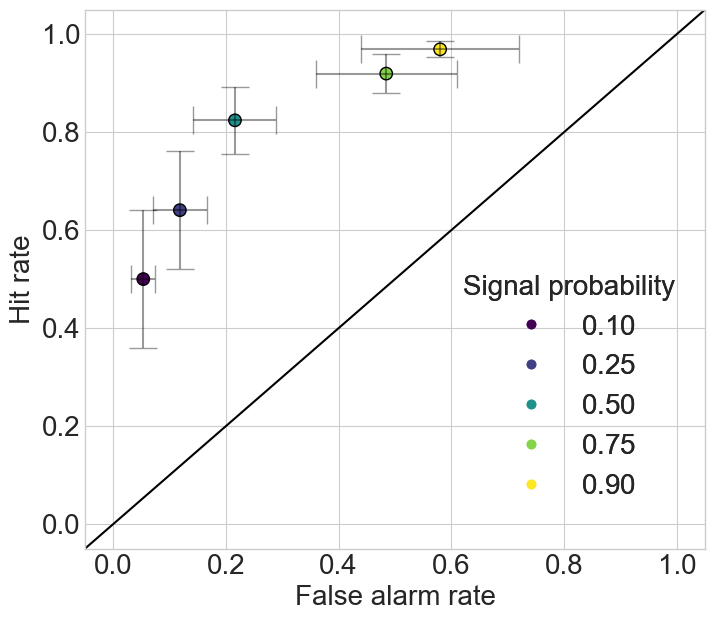

In [6]:
# plot the roc curve:
fig, ax = plt.subplots(figsize=(8, 7))

scatter = ax.scatter(
    x=hit_fa_df["false_alarm_rate"],
    y=hit_fa_df["hit_rate"],
    c=hit_fa_df["discrete_p"],
    cmap=plt.get_cmap("viridis"),
    edgecolors="black",
    s=80,
)

ax.errorbar(
    x=hit_fa_df["false_alarm_rate"],
    y=hit_fa_df["hit_rate"],
    xerr=[
        hit_fa_df["false_alarm_rate"] - hit_fa_df["far_min"],
        hit_fa_df["far_max"] - hit_fa_df["false_alarm_rate"],
    ],
    yerr=[
        hit_fa_df["hit_rate"] - hit_fa_df["hr_min"],
        hit_fa_df["hr_max"] - hit_fa_df["hit_rate"],
    ],
    ls="none",
    color="k",
    capsize=10,
    alpha=0.4,
)

legend1 = ax.legend(
    *scatter.legend_elements(),
    loc="center left",
    bbox_to_anchor=(0.57, 0.3),
    title="Signal probability"
)
ax.add_artist(legend1)
plt.axline((0, 0), slope=1, color="k")
ax.set_xlabel("False alarm rate")
ax.set_ylabel("Hit rate")
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

The different points correspond to the different values of signal probability (see the colour bar). You can see how the hit and false alarm proportions change with the signal probability. The diagonal line across the plot shows where hit rate = false alarm rate.

The error bars show the approximate 95% confidence intervals in the x- and y directions (±2 standard errors of the mean). These confidence intervals give some idea about the range the true hit rate and false alarm rate.
They're similar to the confidence intervals you computed two weeks ago for your psychometric functions using bootstrapping.

The ROC plot shows you quantitatively how the participant traded off hits and false alarms in the task.

### <span style="color:blue">Task 2</span>

The confidence intervals in the plot above are not symmetric. For example, for some points, the horizontal confidence interval is narrow whereas the vertical confidence interval is wide. Write a short paragraph describing why this is the case.

Hint: consider how confidence intervals depend on the amount of data collected (more data = narrower confidence intervals). Look at the print out of `hit_fa_df` in the table above -- how many trials were performed for each cell?

*If the number of trials for noise or signal is bigger, the relevant confidence intervall gets smaller because there is more information for locating where rate should be. If the signal probability is increasing, then the confidence intervall for the hit rate gets smaller and the confidence intervall for the false alarm rate gets wider and vice versa.*



### Plot average dprime curve on ROC plot

A given value of $d^\prime$ implies a curve on the ROC plot.
Now we can plot the curve implied by the observer's average $d^\prime$.


In [7]:
# now compute mean dprime:
mean_dprime = hit_fa_df["dprime"].mean()
print(f"The mean dprime value is {mean_dprime}")

The mean dprime value is 1.5952693336468537


In [8]:
def hit_rate_given_fa_and_sens(dprime, far):
    inv_norm_hr = dprime + norm.ppf(far)
    return norm.cdf(inv_norm_hr)


# add an iso-dprime line to a plotnine plot...
isosensitivity_df = pd.DataFrame({"false_alarm_rate": np.linspace(0, 1, 100)})
isosensitivity_df["hit_rate"] = hit_rate_given_fa_and_sens(
    mean_dprime, isosensitivity_df["false_alarm_rate"]
)
isosensitivity_df["discrete_p"] = None  # need to add this to avoid plotnine complaining

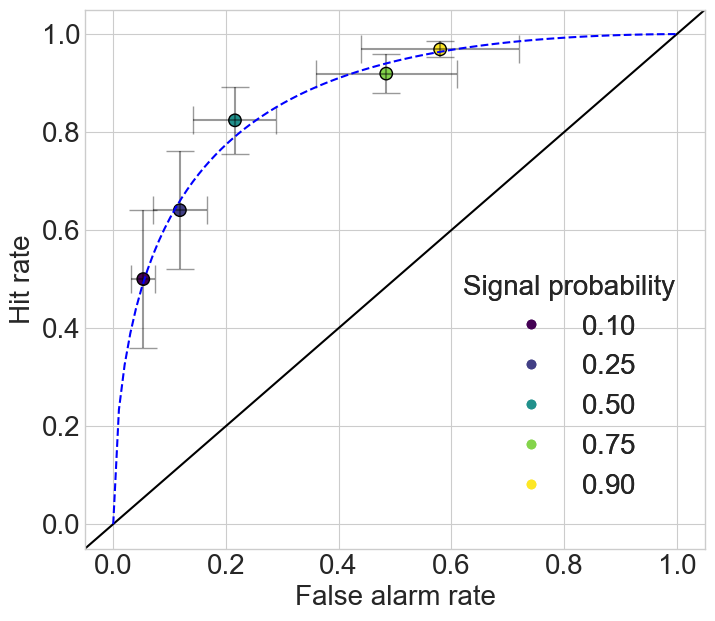

In [9]:
# show curve
fig.axes[0].plot(
    isosensitivity_df["false_alarm_rate"],
    isosensitivity_df["hit_rate"],
    color="b",
    linestyle="--",
)
fig

### <span style="color:blue">Task 3</span>

The blue curve shows the *isosensitivity* ("iso" = Greek "equal") curve implied by the equal-variance Gaussian SDT model. 

Describe how a decision-maker / participant could move their performance along the isosensitivity curve.
Is this curve a good description of this participant's data?


*The participant can move their performance along the curve by adapting his answers to the desired position. If he wants to be in the lower left he should answer "no" or else if he wants to be in the upper right then he should answer "yes". It is useful as it displays all the significant participant's data, but it is unfortunate that the confidence intervalls are so big. This means that there is too much uncertainty about the isosensitivity that is not represented in the curve itself.*



## Part II: Area under the ROC curve

In this week's mini-lecture, I mentioned that the area under the ROC curve (AUC) can be used as a measure of sensitivity.
If the decision-maker can't discriminate signal from noise at all, then their hit rates will be on average the same as their false alarm rates, and the AUC will be 0.5.
As the decision-maker's performance improves, AUC approaches 1.

How can we compute the AUC?
For any functionally-defined ROC form, the AUC is the integral of the function along the false alarm probability from 0 to 1. Imagine that the ROC is defined by function $R$ such that $\mathrm{P_H} = R(\mathrm{P_F})$, where ${P_H}$ is the hit rate and ${P_F}$ is the false alarm rate. The AUC is therefore:

$$
\text{AUC} = \int_0^1 R(\mathrm{P_F}) d\mathrm{P_F}.
$$

For real data, this integral can either be approximated numerically, or we can assume a functional form for $R$.
If we assume the Equal-Variance Gaussian model, then we end up with the following equation for AUC (see [Wickens (2001), section 4.3, for derivation](https://moodle.tu-darmstadt.de/mod/resource/view.php?id=726912)):

$$
\mathrm{AUC_{EVG}} = \Phi(d^\prime / \sqrt 2),
$$

where $\Phi$ is the cumulative Gaussian distribution.

Below, we compute the AUC for the example data, assuming the EVG model:

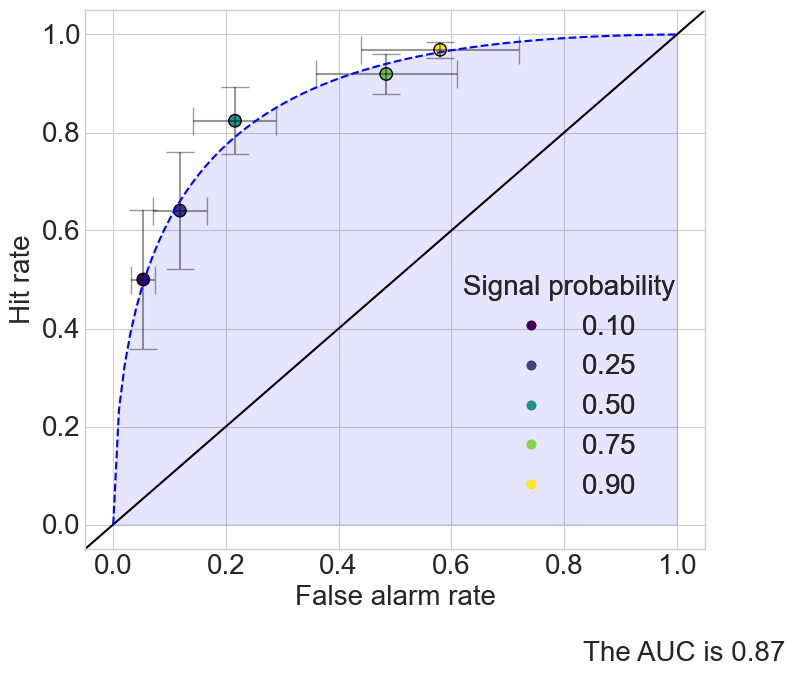

In [10]:
# estimate of AUC assuming equal-variance gaussian model (Wickens, Equation 4.8, p. 68).
auc_evg = np.round(norm.cdf(mean_dprime / np.sqrt(2)), 3)

fig.axes[0].fill_between(
    isosensitivity_df["false_alarm_rate"],
    isosensitivity_df["hit_rate"],
    color="b",
    alpha=0.1,
)
fig.text(1, -0.05, f"The AUC is {auc_evg}", ha="right")
fig

The participant's AUC is 0.87 (computed assuming the average $d^\prime$ and the EVG model).
This is shown by the blue shaded region in the plot above.

We can also do a numerical approximation to the AUC (rather than assuming the EVG model).
One way to do this is with [numpy.trapz](https://numpy.org/doc/stable/reference/generated/numpy.trapz.html), which integrates using a trapezoidal rule:

In [11]:
x = hit_fa_df["false_alarm_rate"].values
y = hit_fa_df["hit_rate"].values

# add 0,0 and 1,1, because we know the curve must start and end there:
x = np.concatenate([[0.0], x, [1.0]])
y = np.concatenate([[0.0], y, [1.0]])
res = np.trapz(y, x)
print(f"The numerically-integrated AUC is {np.round(res, 3)}")

The numerically-integrated AUC is 0.86
